In [ ]:
#### Extracting MFCC's For every audio file
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import librosa
from glob import glob
from google.colab import drive
drive.mount('/content/gdrive')

audio_dataset_path='/content/gdrive/MyDrive/Major_Project/ICBHI_final_database/wave_files/'
data=pd.read_csv('/content/gdrive/MyDrive/Major_Project/ICBHI_final_database/patient_diagnosis.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
aug_diagnosis = pd.read_csv('/content/gdrive/MyDrive/Major_Project/ICBHI_final_database/augmented_features_df_2.csv')

In [ ]:
aug_diagnosis['Disease_Id'].value_counts()

1    560
0    551
3    544
5    520
2    506
4    481
Name: Disease_Id, dtype: int64

In [ ]:
data = aug_diagnosis.values
data = np.delete(data, np.where((data[:, -1] == 6) | (data[:, -1] == 7))[0], axis=0)

In [ ]:
X, y = data[:, :-1], data[:, -1]

In [ ]:
from collections import Counter
counter = Counter(y)

In [ ]:
dict1 = {0:"COPD", 1:"Healthy", 2:"URTI", 3:"Bronchiectasis", 4:"Pneumoina", 5:"Bronchiolitis"}

In [ ]:
label_encoder = LabelEncoder()
y = to_categorical(label_encoder.fit_transform(y))

In [ ]:
y.shape

(3162, 6)

In [ ]:
### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2845, 40)
(317, 40)
(2845, 6)
(317, 6)


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [ ]:
num_labels=y.shape[1]
num_labels

6

Defining the CNN Architecture

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Activation, MaxPooling1D, Dropout
from tensorflow.keras.utils import plot_model,to_categorical
from timeit import default_timer as timer
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad, Adadelta, Adamax
from sklearn import metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from datetime import datetime

In [ ]:
def cnn_model():
    model = Sequential()


    model.add(Conv1D(64, kernel_size=5, activation='relu', input_shape=(40,1)))
    # model.add(MaxPooling1D(2))
    # model.add(Dropout(0.5))

    model.add(Conv1D(64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.3))

    model.add(Conv1D(64, kernel_size=5, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Flatten())

    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    model.add(Dense(200))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    model.add(Dense(200))
    model.add(Activation('relu'))
    model.add(Dropout(0.3))

    model.add(Dense(num_labels))
    model.add(Activation('softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

    return model

Define some callbacks

In [ ]:
#set early stopping criteria
pat = 8 #this is the number of epochs with no improvment after which the training will stop
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

#define the model checkpoint callback -> this will keep on saving the model as a physical file
checkpointer = ModelCheckpoint(filepath='model_90_10_drop_0.3_conlay_2_adam_batch_32.h5',
                               verbose=1, save_best_only=True)

#define a function to fit the model
def fit_and_evaluate(t_x, val_x, t_y, val_y, EPOCHS, BATCH_SIZE):
    start = datetime.now()
    history = cnn_model().fit(t_x, t_y, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping, checkpointer],
              verbose=1, validation_split=0.1)
    duration = datetime.now() - start
    print("Training completed in time: ", duration)
    print("Val Score: ", cnn_model().evaluate(val_x, val_y))
    return history

Train the model with K-fold Cross Val

In [ ]:
n_folds=3
epochs=100
batch_size=32

#save the model history in a list after fitting so that we can plot later
model_history = []

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    t_x, val_x, t_y, val_y = train_test_split(X_train, y_train, test_size=0.2,
                                               random_state = np.random.randint(1,1000, 1)[0])
    model_history.append(fit_and_evaluate(t_x, val_x, t_y, val_y, epochs, batch_size))
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Epoch 1/100
62/64 [============================>.] - ETA: 0s - loss: 1.8248 - accuracy: 0.1774
Epoch 1: val_loss improved from inf to 1.77982, saving model to model_90_10_drop_0.3_conlay_2_adam_batch_32.h5
64/64 [==============================] - 3s 20ms/step - loss: 1.8243 - accuracy: 0.1748 - val_loss: 1.7798 - val_accuracy: 0.1667
Epoch 2/100
64/64 [==============================] - ETA: 0s - loss: 1.7583 - accuracy: 0.2334
Epoch 2: val_loss improved from 1.77982 to 1.64759, saving model to model_90_10_drop_0.3_conlay_2_adam_batch_32.h5
64/64 [==============================] - 1s 16ms/step - loss: 1.7583 - accuracy: 0.2334 - val_loss: 1.6476 - val_accuracy: 0.3377
Epoch 3/100
62/64 [============================>.] - ETA: 0s - loss: 1.5738 - accuracy: 0.3432
Epoch 3: val_loss improved from 1.64759 to 1.31076, saving model to model_90_10_drop_0.3_conlay_2_adam_batch_32.h5
64/64 [==============================] - 1s 19ms/step - loss: 1.5729 - accuracy: 0.3408 - val

In [ ]:
np.save('history_90_10_drop_0.3_conlay_2_adam_batch_32.npy',model_history)

In [ ]:
model_history = np.load('history_90_10_drop_0.3_conlay_2_adam_batch_32.npy',allow_pickle=True)

In [ ]:
model_history

array([<keras.callbacks.History object at 0x7f4d2e384a90>,
       <keras.callbacks.History object at 0x7f4d236727d0>], dtype=object)

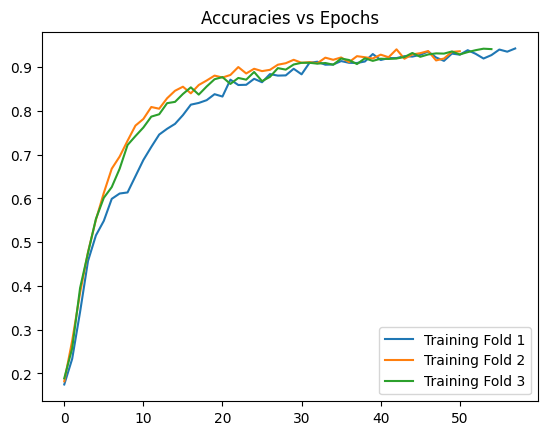

In [ ]:
plt.title('Accuracies vs Epochs')
plt.plot(model_history[0].history['accuracy'], label='Training Fold 1')
plt.plot(model_history[1].history['accuracy'], label='Training Fold 2')
plt.plot(model_history[2].history['accuracy'], label='Training Fold 3')
plt.legend()
plt.show()

<ipython-input-115-284317f5ed58>:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 1, 1)


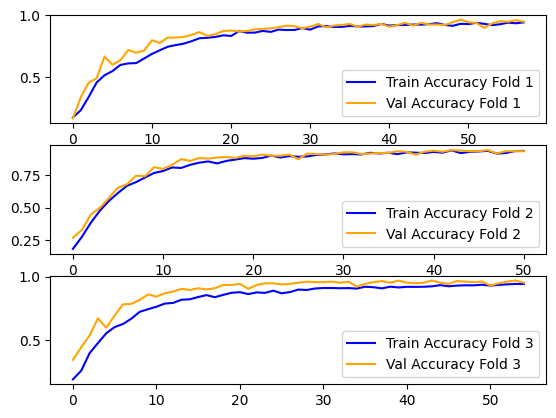

In [ ]:
plt.title('Train Accuracy vs Val Accuracy')
plt.subplot(3, 1, 1)
plt.plot(model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='blue')
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='orange')
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='blue' )
plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='orange')
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='blue' )
plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='orange')
plt.legend()
plt.show()

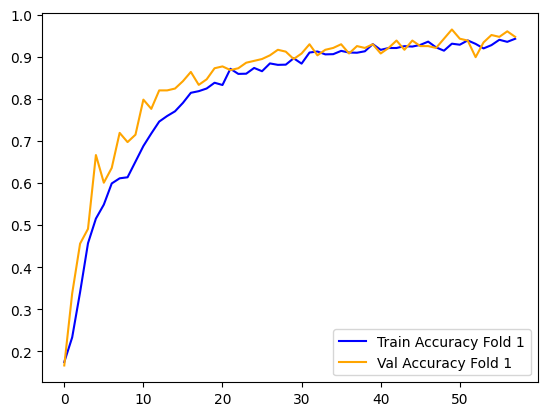

In [ ]:
plt.plot(model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='blue')
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='orange')
plt.legend()
plt.show()

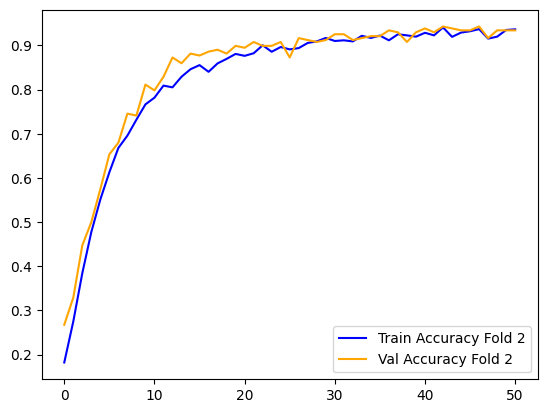

In [ ]:
plt.plot(model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='blue' )
plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='orange')
plt.legend()
plt.show()

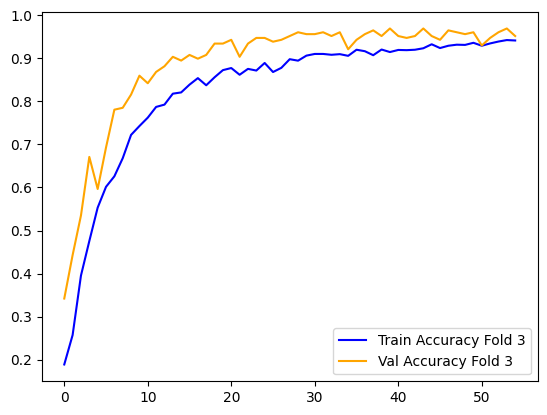

In [ ]:
plt.plot(model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='blue' )
plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='orange')
plt.legend()
plt.show()

In [ ]:
model1 = tf.keras.models.load_model('model_90_10_drop_0.3_conlay_2_adam_batch_32.h5')

In [ ]:
model1.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_60 (Conv1D)          (None, 36, 64)            384       
                                                                 
 conv1d_61 (Conv1D)          (None, 32, 64)            20544     
                                                                 
 max_pooling1d_22 (MaxPoolin  (None, 16, 64)           0         
 g1D)                                                            
                                                                 
 dropout_126 (Dropout)       (None, 16, 64)            0         
                                                                 
 conv1d_62 (Conv1D)          (None, 12, 64)            20544     
                                                                 
 dropout_127 (Dropout)       (None, 12, 64)            0         
                                                     

In [ ]:
# Evaluating the model on the training and testing set
score_1 = model1.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy: ", score_1[1])

score_2 = model1.evaluate(X_test, y_test, verbose=0)
print("Testing Accuracy: ", score_2[1])

Training Accuracy:  0.9609841704368591
Testing Accuracy:  0.9463722109794617


In [ ]:
print("Training loss: ", score_1[0])
print("Testing loss: ", score_2[0])

Training loss:  0.09634323418140411
Testing loss:  0.14831823110580444


10/10 [==============================] - 0s 5ms/step
                precision    recall  f1-score   support

          COPD       1.00      0.90      0.95        62
       Healthy       0.89      0.87      0.88        47
          URTI       0.89      0.93      0.91        55
Bronchiectasis       0.96      1.00      0.98        43
     Pneumoina       0.95      0.98      0.97        59
 Bronchiolitis       0.98      1.00      0.99        51

      accuracy                           0.95       317
     macro avg       0.95      0.95      0.95       317
  weighted avg       0.95      0.95      0.95       317



<Axes: xlabel='Predicted', ylabel='Actual'>

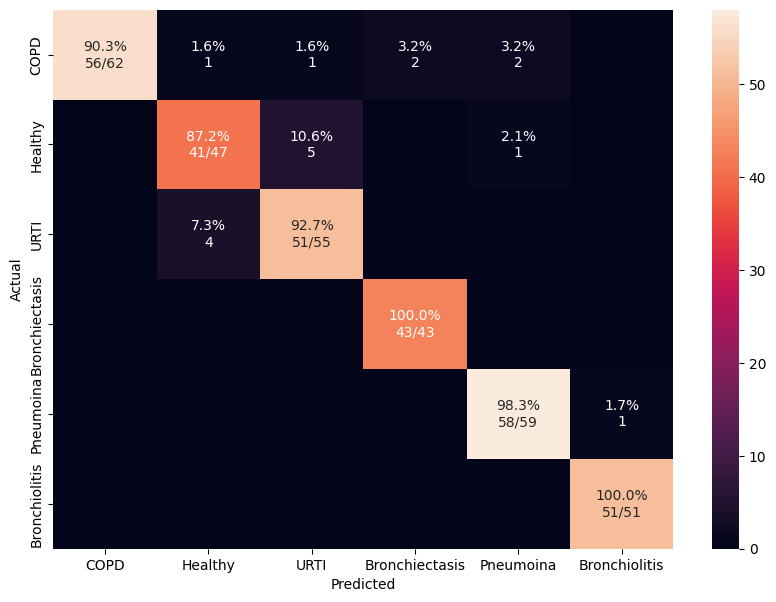

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
matrix_index = ["COPD", "Healthy", "URTI", "Bronchiectasis", "Pneumoina", "Bronchiolitis"]

preds = model1.predict(X_test)
classpreds = np.argmax(preds, axis=1) # predicted classes
y_testclass = np.argmax(y_test, axis=1) # true classes

cm = confusion_matrix(y_testclass, classpreds)
print(classification_report(y_testclass, classpreds, target_names=matrix_index))

# Get percentage value for each element of the matrix
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)


# Display confusion matrix
df_cm = pd.DataFrame(cm, index = matrix_index, columns = matrix_index)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(10,7))
sn.heatmap(df_cm, annot=annot, fmt='')

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
count = []
for i in counter.keys():
  count.append(int(i))
count.sort()
result=[]
for label in count:
  precision,recall,f_score,support = precision_recall_fscore_support(np.array(y_testclass) == label,np.array(classpreds) == label)
  result.append([dict1[label],recall[0],recall[1],recall[1],precision[1],f_score[1],support[1]])
df = pd.DataFrame(result,columns=["label","Specificity","Sensitivity","Recall","Precision","f_score","support"])
df

,label,Specificity,Sensitivity,Recall,Precision,f_score,support
0,COPD,1.000000,0.903226,0.903226,1.000000,0.949153,62
1,Healthy,0.981481,0.872340,0.872340,0.891304,0.881720,47
2,URTI,0.977099,0.927273,0.927273,0.894737,0.910714,55
3,Bronchiectasis,0.992701,1.000000,1.000000,0.955556,0.977273,43
4,Pneumoina,0.988372,0.983051,0.983051,0.950820,0.966667,59
5,Bronchiolitis,0.996241,1.000000,1.000000,0.980769,0.990291,51
